In [1]:
import os

import csv
import pandas as pd
import pickle

import cv2
from skimage.measure import find_contours
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator, interp1d
from scipy.optimize import curve_fit

# LED 150040GS73220 

## Luminescence Data 

### Loading the file and pre-processing the data

In [2]:
# Load the image and convert to RGB
image = cv2.imread("E://Hardware Design/Electronics/PCB/OENN/Modular V2/150040GS73220 Luminuous Intensity.PNG")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### Extracting data from the plot

In [3]:
# Mask the green color
lower_green = np.array([35, 50, 50])
upper_green = np.array([85, 255, 255])
hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
green_mask = cv2.inRange(hsv, lower_green, upper_green)

# Detect edges
edges = cv2.Canny(green_mask, 50, 150)

# Extract pixel coordinates
y, x = np.where(edges == 255)
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

# Convert pixel coordinates to data values using provided reference points
ref_pixel_x1, ref_pixel_y1 = x_sorted[0], y_sorted[0]
ref_pixel_x2, ref_pixel_y2 = x_sorted[-1], y_sorted[-1]
ref_data_x1, ref_data_y1 = 0, 0
ref_data_x2, ref_data_y2 = 35, 1100
x_scale_factor = (ref_data_x2 - ref_data_x1) / (ref_pixel_x2 - ref_pixel_x1)
y_scale_factor = (ref_data_y2 - ref_data_y1) / (ref_pixel_y2 - ref_pixel_y1)
data_x = ref_data_x1 + (x_sorted - ref_pixel_x1) * x_scale_factor
data_y = ref_data_y1 + (y_sorted - ref_pixel_y1) * y_scale_factor
data_points = list(zip(data_x, data_y))

### Filtering the Data

In [4]:
# Filter out data points with negative y-values
filtered_data_points = [(x_val, y_val) for x_val, y_val in data_points if y_val >= 0]

# Save the filtered data points to a CSV file
with open("out/150040GS73220 VI.csv", 'w') as f:
    f.write("Forward Current,Luminous Intensity\n")
    for point in filtered_data_points:
        f.write(f"{point[0]},{point[1]}\n")

### Fitting the Data

In [5]:
# Split data into input (Forward Current) and output (Luminous Intensity)
forward_currents = np.array([point[0] for point in filtered_data_points])
luminous_intensities = np.array([point[1] for point in filtered_data_points])

# Fit a polynomial (let's start with a quadratic fit: degree=2)
coefficients = np.polyfit(forward_currents, luminous_intensities, 2)
polynomial = np.poly1d(coefficients)

# To predict luminous intensity for a given forward current
def predict_luminous_intensity(forward_current):
    return polynomial(forward_current)

# Example: Predict luminous intensity for forward current value of 20
predicted_value = predict_luminous_intensity(20)
print(f"Predicted Luminous Intensity for Forward Current of 20: {predicted_value}")


Predicted Luminous Intensity for Forward Current of 20: 747.225680063252


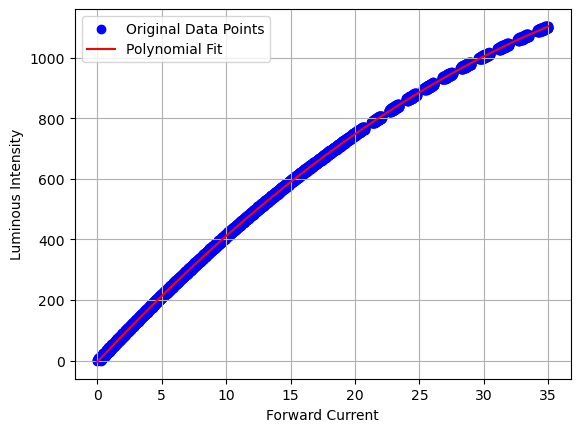

In [6]:
predicted_intensities = predict_luminous_intensity(forward_currents)
plt.scatter(forward_currents, luminous_intensities, color='blue', label='Original Data Points')
plt.plot(forward_currents, predicted_intensities, color='red', label='Polynomial Fit')
plt.xlabel("Forward Current")
plt.ylabel("Luminous Intensity")
plt.legend()
plt.grid(True)
plt.show()

## Relative Luminous Intensity

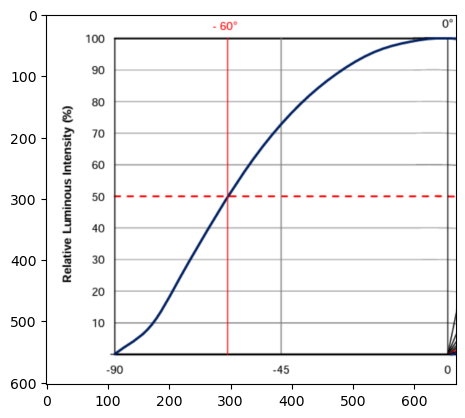

In [7]:
image = cv2.imread("E://Hardware Design/Electronics/PCB/OENN/Modular V2/150040GS73220 Viewing Angle Crop.PNG")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)

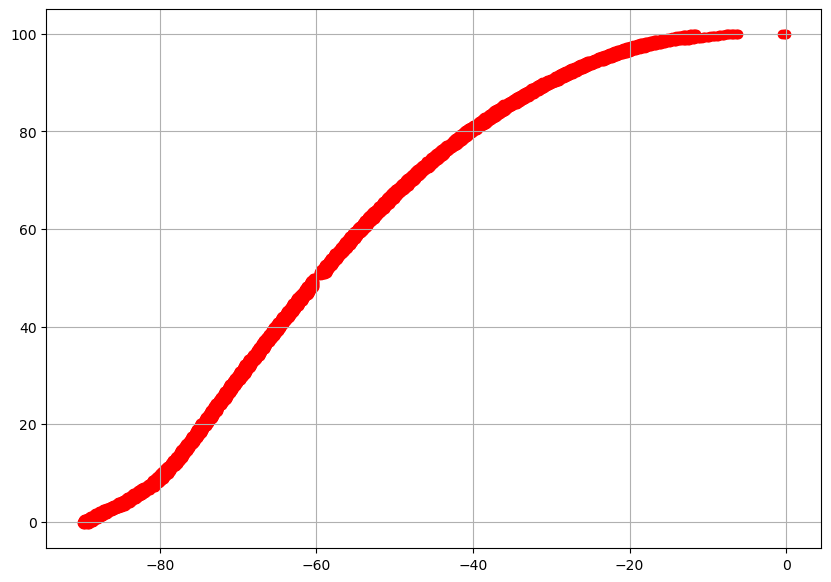

In [8]:
# Mask the color #001F5F
lower_color = np.array([95, 31, 15])
upper_color = np.array([115, 255, 255])
hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
color_mask = cv2.inRange(hsv, lower_color, upper_color)

# Detect edges
edges = cv2.Canny(color_mask, 50, 150)

# Extract pixel coordinates
y, x = np.where(edges == 255)
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

# Convert pixel coordinates to data values using provided reference points
ref_pixel_x1, ref_pixel_y1 = x_sorted[0], y_sorted[0]
ref_pixel_x2, ref_pixel_y2 = x_sorted[-1], y_sorted[-1]
ref_data_x1, ref_data_y1 = -90, 0
ref_data_x2, ref_data_y2 = 0, 100
x_scale_factor = (ref_data_x2 - ref_data_x1) / (ref_pixel_x2 - ref_pixel_x1)
y_scale_factor = (ref_data_y2 - ref_data_y1) / (ref_pixel_y2 - ref_pixel_y1)
data_x = ref_data_x1 + (x_sorted - ref_pixel_x1) * x_scale_factor
data_y = ref_data_y1 + (y_sorted - ref_pixel_y1) * y_scale_factor
data_points = list(zip(data_x, data_y))

# Filter out data points between (-60, 50) and (0, 0)
filtered_data_points = [(x_val, y_val) for x_val, y_val in data_points if not (-60 <= x_val <= 1 and -1 <= y_val <= 50) and (x_val >= -90 and y_val <= 100)]

# Save the filtered data points to a CSV file
with open("out/150040GS73220 Viewing Angle.csv", 'w') as f:
    f.write("X,Y\n")
    for point in filtered_data_points:
        f.write(f"{point[0]},{point[1]}\n")

# Plot the data points
x_values = [point[0] for point in filtered_data_points]
y_values = [point[1] for point in filtered_data_points]
plt.figure(figsize=(10, 7))
plt.grid(True)
plt.scatter(x_values, y_values, color='red')

# Show the plot
plt.show()


### Fitting the Data

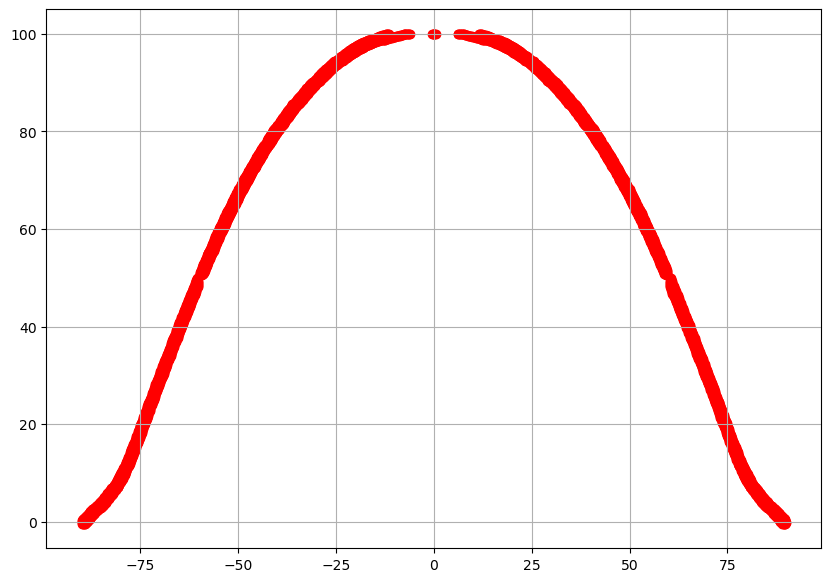

In [9]:
# Mirror the data points around the y-axis
mirrored_data_points = [(x_val, y_val) for x_val, y_val in filtered_data_points]
mirrored_data_points.reverse()
mirrored_data_points = [(-x_val, y_val) for x_val, y_val in mirrored_data_points]

# Combine the original and mirrored data points
extended_data_points = filtered_data_points + mirrored_data_points

# Plot the data points
plt.figure(figsize=(10, 7))
x_values = [point[0] for point in extended_data_points]
y_values = [point[1] for point in extended_data_points]
plt.scatter(x_values, y_values, color='red')
plt.grid(True)
# Show the plot
plt.show()

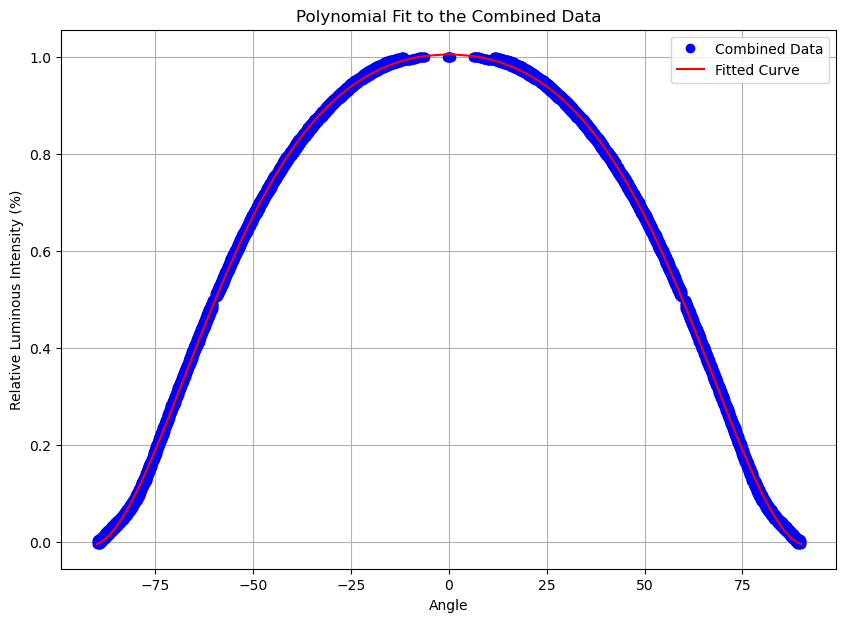

In [10]:
# Split data into input (Forward Current) and output (Luminous Intensity)
angles = np.array([point[0] for point in extended_data_points])
relative_sensitivity = np.array([point[1] for point in extended_data_points])
relative_sensitivity = relative_sensitivity/np.max(relative_sensitivity)

# Fitting a sixth order polynomial
luminuous_intensity_fit = np.polynomial.Polynomial.fit(angles, relative_sensitivity, 6)

# Plotting the fitted polynomial
plt.figure(figsize=(10, 7))
plt.plot(angles, relative_sensitivity, 'o', label="Combined Data", color='blue')
plt.plot(angles, luminuous_intensity_fit(np.array(angles)), '-', label="Fitted Curve", color='red')
plt.title("Polynomial Fit to the Combined Data")
plt.xlabel("Angle")
plt.ylabel("Relative Luminous Intensity (%)")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Evaluate the 1D fit function
alpha_values = np.linspace(-90, 90, 1000)
luminous_intensity_1D = luminuous_intensity_fit(alpha_values)

# Create a 2D grid of alpha and beta values
alpha_grid, beta_grid = np.meshgrid(alpha_values, alpha_values)

# Obtain 2D luminous intensity values. For this example, I'm just averaging the 1D values.
luminous_intensity_2D = 0.5 * (luminuous_intensity_fit(alpha_grid) + luminuous_intensity_fit(beta_grid))

# Create a 2D function by interpolating the 2D luminous intensity values
fit_func = RegularGridInterpolator((alpha_values, alpha_values), luminous_intensity_2D)

# Evaluate the 2D function at the desired alpha and beta values
result = fit_func((alpha_grid.ravel(), beta_grid.ravel()))

# Reshape results to 100x100
result = result.reshape((1000, 1000))


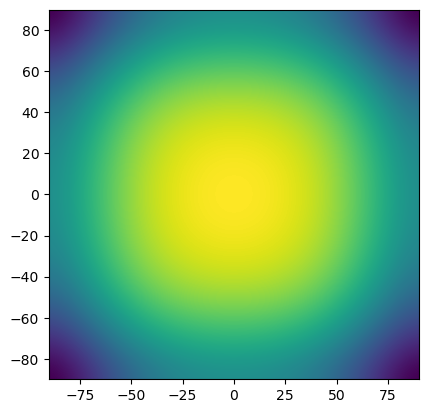

In [12]:
plt.imshow(result, extent=[-90, 90, -90, 90])

# LED VLMTG1400

## Luminescence

### Loading and pre-processing the image

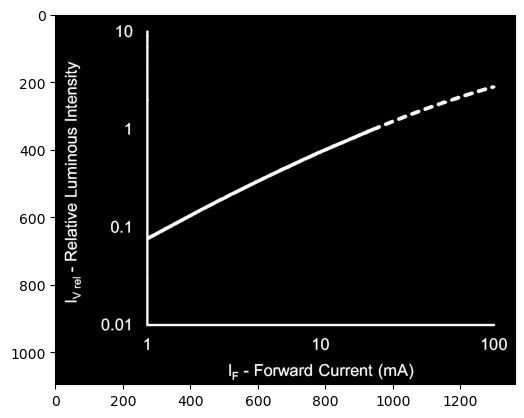

In [13]:
# Loading the file
file_loc = "E://Hardware Design/Electronics/PCB/OENN/Modular V2/VLMTG1400 Luminescence.PNG"
image = cv2.imread(file_loc)

# Converting to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Making the image into a binary image with inverted colors
_, binary_image = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY_INV)
binary_image_crop = binary_image[25:940, 250:1325]

# Visualizing the file
plt.imshow(binary_image, cmap='gray')

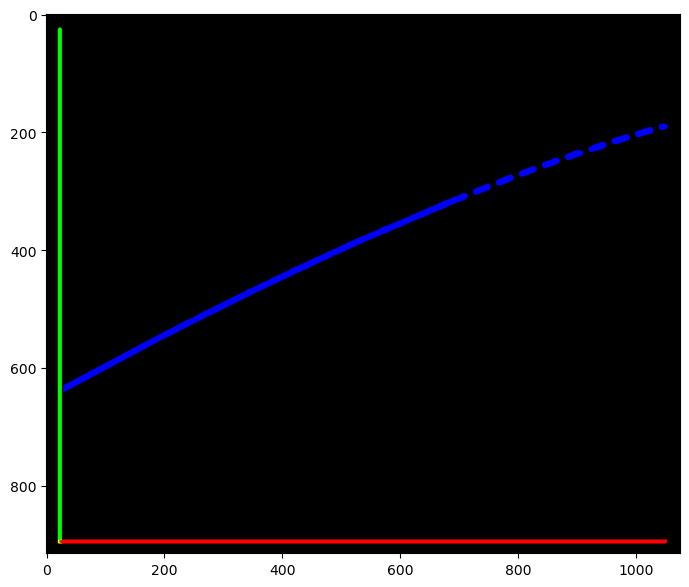

True

In [14]:
## Manually finding the axis lines

# x-axis
x1_x_ax, y1_x_ax = 24, 895
x2_x_ax, y2_x_ax = 1050, 895

x1_x_real, y1_x_real = 1, 0.01
x2_x_real, y2_x_real = 100, 0.01

# y-axis
x1_y_ax, y1_y_ax = 23, 24
x2_y_ax, y2_y_ax = 23, 892

x1_y_real, y1_y_real = 1, 0.01
x2_y_real, y2_y_real = 1, 10

# making a copy of the image for further non-destructive processing
col_image_crop = cv2.cvtColor(binary_image_crop.copy(), cv2.COLOR_GRAY2RGB)

# Draw the line on the binary image
cv2.line(col_image_crop, (x1_x_ax, y1_x_ax), (x2_x_ax, y2_x_ax), (255, 0, 0), 4)
cv2.line(col_image_crop, (x1_y_ax, y1_y_ax), (x2_y_ax, y2_y_ax), (0, 255, 0), 4)

# Setting the rest of the elements to zero
col_image_crop[:891,:,0] = 0 # The y-axis column and data in channel 0
col_image_crop[:,27:,1] = 0 # The x-axis and the data in channel 1
col_image_crop[:,0:26,2] = 0 # The y-axis in channel 2
col_image_crop[800:,:,2] = 0 # The x-axis in channel 2
col_image_crop[0:666,0:29,2] = 0 # The additional noise in channel 2
col_image_crop[650:,:,2] = 0 # The additional noise in channel 2

# Overlay the line on the binary image temporarily
fig, ax = plt.subplots(figsize=(10, 7))

# Display the binary image with the detected lines overlaid on top
plt.imshow(col_image_crop)
plt.show()

# Saving the image for uploading to ChatGPT for further analysis
cv2.imwrite("out/cleaned_data.png", col_image_crop, [cv2.IMWRITE_PNG_COMPRESSION, 9])


### Extracting the data

In [38]:
# Function to extract data points from the plot
def extract_data_from_log_plot(image, x_range, y_range):
    # Split the image into its respective channels
    # Assuming the channels are in the order of BGR as is standard with cv2
    channels = cv2.split(image)

    # Initialize a list to hold the data points
    data_points = []

    # Get the number of rows and columns in the image
    rows, cols, _ = image.shape

    # Assuming the x-axis is at the bottom of the image and the y-axis is on the left,
    # We iterate over the data channel (assuming it is the red channel here) and check for non-black pixels
    for i in range(rows):
        for j in range(cols):
            # If the pixel is not black (data is present), we process it
            if channels[2][i, j] != 0:
                # The x value is scaled according to its position and the given x_range
                x_value = np.logspace(np.log10(x_range[0]), np.log10(x_range[1]), cols)[j]
                # The y value is scaled according to its position and the given y_range
                y_value = np.logspace(np.log10(y_range[0]), np.log10(y_range[1]), rows)[-i-1]
                # Append the (x, y) tuple to the data_points list
                data_points.append((x_value, y_value))

    return data_points

# Define the x and y range based on the log scale
x_log_range = [1, 100]  # given log scale for x-axis
y_log_range = [0.01, 10]  # given log scale for y-axis

# Extract the data points
data_points = extract_data_from_log_plot(col_image_crop, x_log_range, y_log_range)

# Convert to a numpy array for easier handling
data_points_array = np.array(data_points)

### Converting to absolute values

In [16]:
# Given absolute calibration point
current_calibration = 20  # in mA
luminescence_calibration = 1400  # absolute luminescence value

# Find the relative luminescence value corresponding to the given current_calibration in the extracted data
# Since we are dealing with a log-log plot, we need to find the closest point in log space
log_current = np.log10(data_points_array[:, 0])
index = (np.abs(log_current - np.log10(current_calibration))).argmin()
relative_luminescence_calibration = data_points_array[index, 1]

# Calculate the conversion factor from relative to absolute luminescence
conversion_factor = luminescence_calibration / relative_luminescence_calibration

# Apply the conversion factor to all relative luminescence values to get absolute values
data_points_array[:, 1] *= conversion_factor

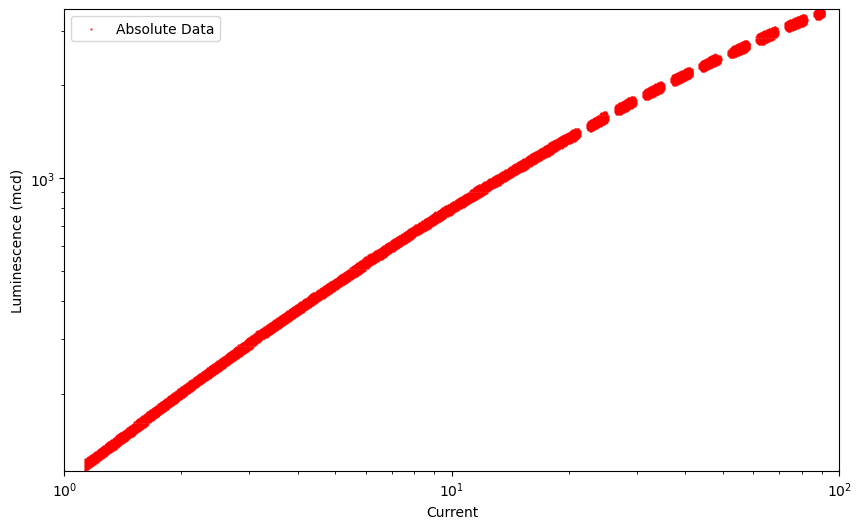

In [17]:
plt.figure(figsize=(10, 6))
plt.xscale('log')
plt.yscale('log')
plt.scatter(data_points_array[:, 0], data_points_array[:, 1],c='red', label='Absolute Data', s=1, marker='.')
plt.xlim(x_log_range)
plt.ylim([min(data_points_array[:, 1]), max(data_points_array[:, 1])])

plt.xlabel('Current')
plt.ylabel('Luminescence (mcd)')
plt.legend()
plt.show()

### Fitting the model

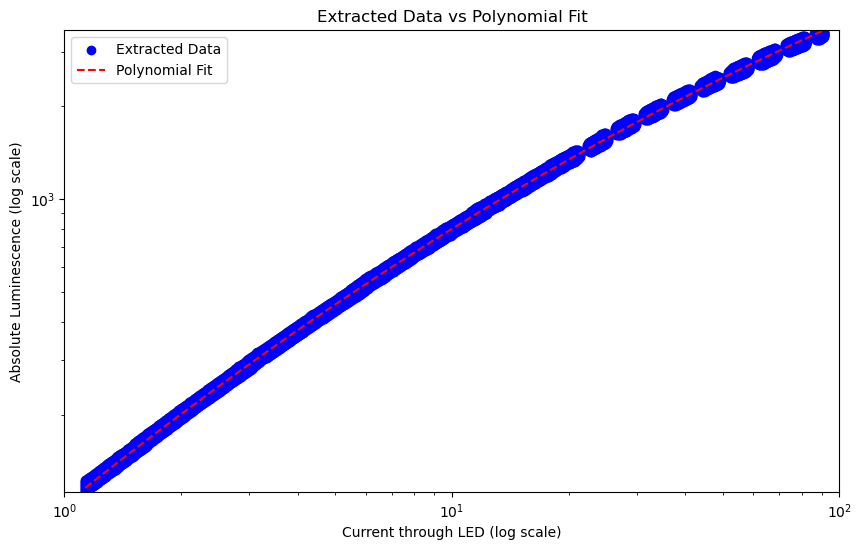

In [18]:
# Define a function for fitting a polynomial to the data
def fit_polynomial(x_data, y_data, degree):
    # Fit the polynomial
    coeffs = np.polyfit(x_data, y_data, degree)
    # Generate a polynomial function from the coefficients
    p = np.poly1d(coeffs)
    return p

# Fit a second-degree polynomial to the data (in log-log space for better handling of wide value ranges)
degree = 2
polynomial_model = fit_polynomial(np.log10(data_points_array[:, 0]), np.log10(data_points_array[:, 1]), degree)

# Predict the luminescence using the polynomial model
log_current_data = np.log10(data_points_array[:, 0]).reshape(-1, 1)
log_current_data_fine = np.linspace(min(log_current_data), max(log_current_data), 1000)
luminescence_polynomial_fitted = 10**polynomial_model(log_current_data_fine)

# Plot both the extracted data and the polynomial fitted model for comparison
plt.figure(figsize=(10, 6))
plt.xscale('log')
plt.yscale('log')
plt.scatter(data_points_array[:, 0], data_points_array[:, 1], c='blue', label='Extracted Data')
plt.plot(10**log_current_data_fine, luminescence_polynomial_fitted, c='red', linestyle='--', label='Polynomial Fit')
plt.xlim(x_log_range)
plt.ylim([min(data_points_array[:, 1]), max(data_points_array[:, 1])])
plt.xlabel('Current through LED (log scale)')
plt.ylabel('Absolute Luminescence (log scale)')
plt.title('Extracted Data vs Polynomial Fit')
plt.legend()
plt.show()

## Voltage-Current Plot

### Reading and Preprocessing the file

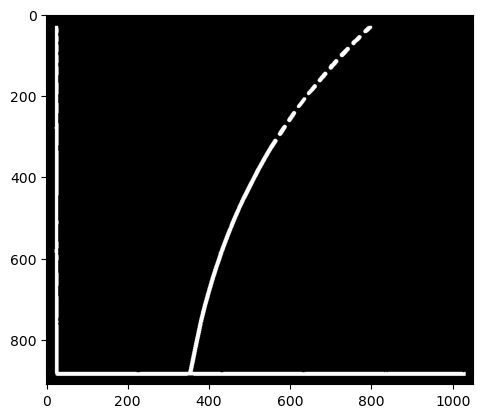

In [19]:
# File Location
file_loc = "E://Hardware Design/Electronics/PCB/OENN/Modular V2/VLMTG1400 Voltage Current.PNG"

# Load the image
image = cv2.imread(file_loc)

# Converting to binary inverted image
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY_INV)

# Cropping the image to leave out the text
binary_image_crop = binary_image[10:920, 250:1300]

# Converting to RGB for further processing
col_image_crop = cv2.cvtColor(binary_image_crop.copy(), cv2.COLOR_GRAY2RGB)

# Visualizing the file
plt.imshow(col_image_crop, cmap='gray')


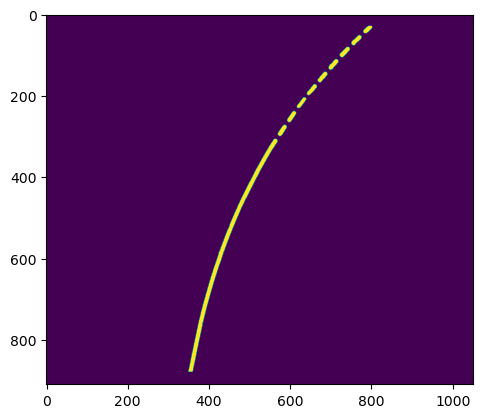

In [20]:
# Setting channel 0 to x-axis
col_image_crop[880:889, 26:1031, 0] = 255
for i in range(col_image_crop.shape[0]):
    for j in range(col_image_crop.shape[1]):
        if i < 889 or i > 880 or j < 26 or j > 1031:
            col_image_crop[i, j, 1] = 0

# Setting channel 1 to y-axis
col_image_crop[29:883, 22:30, 1] = 255
for i in range(col_image_crop.shape[0]):
    for j in range(col_image_crop.shape[1]):
        if i < 29 or i > 882 or j < 22 or j > 29:
            col_image_crop[i, j, 1] = 0

# Setting channel 2 to data
col_image_crop[29:883, 20:32, 2] = 0
col_image_crop[880:892, 24:1033, 2] = 0
col_image_crop[:,0:200, 2] = 0

plt.imshow(col_image_crop[...,2])


### Extracting the data

In [21]:
# Function to extract data points from the plot
def extract_data_from_plot(image, x_range, y_range, log_scale=False):
    # Split the image into its respective channels
    # Assuming the channels are in the order of BGR as is standard with cv2
    channels = cv2.split(image)

    # Initialize a list to hold the data points
    data_points = []

    # Get the number of rows and columns in the image
    rows, cols, _ = image.shape

    # Assuming the x-axis is at the bottom of the image and the y-axis is on the left,
    # We iterate over the data channel (assuming it is the red channel here) and check for non-black pixels
    for i in range(rows):
        for j in range(cols):
            # If the pixel is not black (data is present), we process it
            if channels[2][i, j] != 0:
                # The x value is scaled according to its position and the given x_range
                if log_scale:
                    x_value = np.logspace(np.log10(x_range[0]), np.log10(x_range[1]), cols)[j]
                else:
                    x_value = np.linspace(x_range[0], x_range[1], cols)[j]
                # The y value is scaled according to its position and the given y_range
                if log_scale:
                    y_value = np.logspace(np.log10(y_range[0]), np.log10(y_range[1]), rows)[-i-1]
                else:
                    y_value = np.linspace(y_range[0], y_range[1], rows)[-i-1]
                # Append the (x, y) tuple to the data_points list
                data_points.append((x_value, y_value))

    return data_points

# Define the x and y range based on the log scale
x_range = [1.5, 4]  # given log scale for x-axis
y_range = [1, 100]  # given log scale for y-axis

# Extract the data points
data_points = extract_data_from_plot(col_image_crop, x_range, y_range)

# Convert to a numpy array for easier handling
data_points_array = np.array(data_points)


In [22]:
# Define the output file path
output_file_path = os.path.join('out', 'VLMTG1400 VI.csv')

# Save the data points to a CSV file
with open(output_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Voltage (V)', 'Current (mA)'])
    for point in data_points_array:
        writer.writerow([point[0], point[1]])

print(f"Data saved to {output_file_path}")

Data saved to out\VLMTG1400 VI.csv


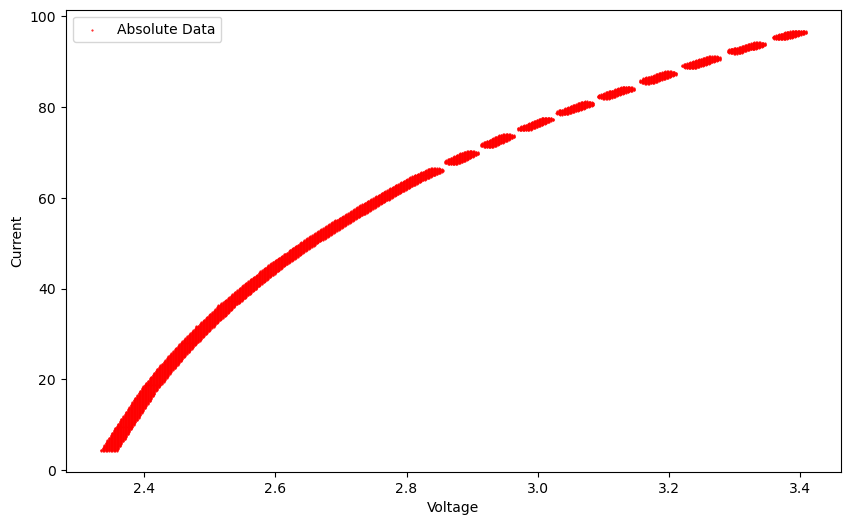

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(data_points_array[:, 0], data_points_array[:, 1], c='red', label='Absolute Data', s=1, marker='.')

plt.xlabel('Voltage')
plt.ylabel('Current')
plt.legend()
plt.show()

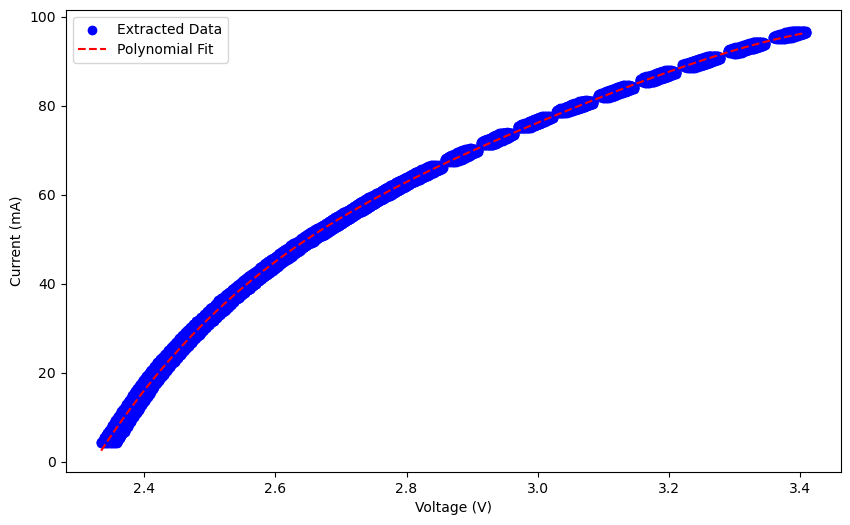

In [24]:
def fit_polynomial(x_data, y_data, degree):
    # Fit the polynomial
    coeffs = np.polyfit(x_data, y_data, degree)
    # Generate a polynomial function from the coefficients
    p = np.poly1d(coeffs)
    return p

# Fit a second-degree polynomial to the data (in log-log space for better handling of wide value ranges)
degree = 4
polynomial_model = fit_polynomial(data_points_array[:, 0], data_points_array[:, 1], degree)

# Predict the luminescence using the polynomial model
current_data = data_points_array[:, 0]
current_data_fine = np.linspace(min(current_data), max(current_data), 1000)
luminescence_polynomial_fitted = polynomial_model(current_data_fine)

# Plot both the extracted data and the polynomial fitted model for comparison
plt.figure(figsize=(10, 6))
plt.scatter(data_points_array[:, 0], data_points_array[:, 1], c='blue', label='Extracted Data')
plt.plot(current_data_fine, luminescence_polynomial_fitted, c='red', linestyle='--', label='Polynomial Fit')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (mA)')
plt.legend()
plt.show()

## Directionality Plot

### Reading in Data and Preprocessing

In [25]:
# Load the image
img_path_x = 'E://Hardware Design/Electronics/PCB/OENN/Modular V2/VLMTG1400 Angle X.PNG'
img_path_y = 'E://Hardware Design/Electronics/PCB/OENN/Modular V2/VLMTG1400 Angle Y.PNG'
img_x = cv2.imread(img_path_x)
img_y = cv2.imread(img_path_y)

# Convert to RGB and isolate red channel
img_rgb_x = cv2.cvtColor(img_x, cv2.COLOR_BGR2RGB)
img_rgb_y = cv2.cvtColor(img_y, cv2.COLOR_BGR2RGB)
red_channel_x = img_rgb_x[:, :, 0]
red_channel_y = img_rgb_y[:, :, 0]

### Extracting the datapoints

In [26]:
# Threshold the red channel to get the data points
_, red_thresh_x = cv2.threshold(red_channel_x, 200, 255, cv2.THRESH_BINARY)
_, red_thresh_y = cv2.threshold(red_channel_y, 200, 255, cv2.THRESH_BINARY)

# Find contours and pick the largest one (assuming it is the data curve)
contours_x, _ = cv2.findContours(red_thresh_x, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_y, _ = cv2.findContours(red_thresh_y, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour_x = max(contours_x, key=cv2.contourArea)
largest_contour_y = max(contours_y, key=cv2.contourArea)

# Assuming the center of the plot is the image center
center_x, center_y = 756, 927

# Convert contour points to polar coordinates
data_points_x = [(np.arctan2(center_y - y, x - center_x) * (180 / np.pi),
                np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2))
               for point in largest_contour_x for x, y in point]

data_points_y = [(np.arctan2(center_y - y, x - center_x) * (180 / np.pi),
                np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2))
               for point in largest_contour_y for x, y in point]

In [74]:
# Create DataFrame, normalize intensity, sort by angle, and save to CSV
df_x = pd.DataFrame(data_points_x, columns=['Angle', 'Intensity'])
df_y = pd.DataFrame(data_points_y, columns=['Angle', 'Intensity'])

df_x['Intensity'] = df_x['Intensity'] / df_x['Intensity'].max()
df_y['Intensity'] = df_y['Intensity'] / df_y['Intensity'].max()

df_x.sort_values(by='Angle', inplace=True)
df_y.sort_values(by='Angle', inplace=True)

### Visualizing the data and saving to a CSV file 

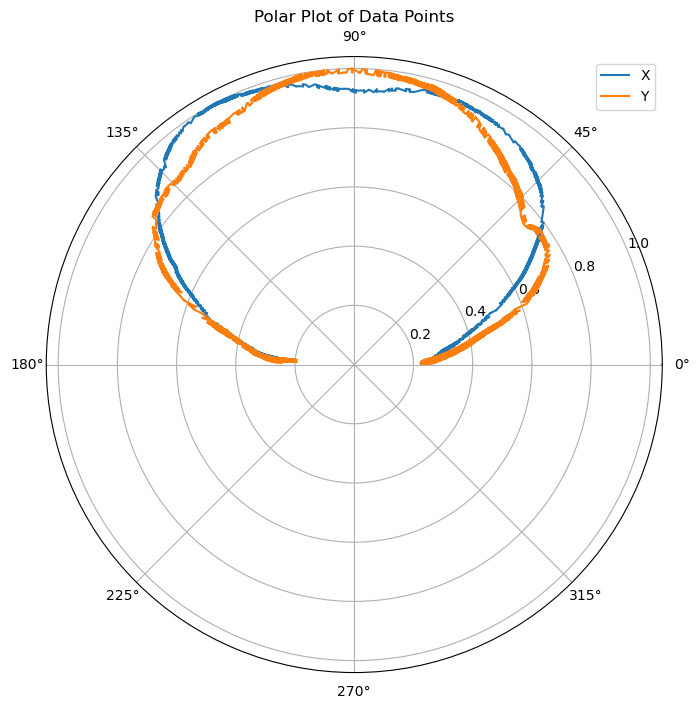

In [71]:
# Convert the angle from degrees to radians
# angles = np.radians(df_y['Angle'])

# Plot the polar graph
plt.figure(figsize=(8, 8))
plt.polar(np.radians(df_x['Angle']), df_x['Intensity'], label='X')
plt.polar(np.radians(df_y['Angle']), df_y['Intensity'], label='Y')
plt.title('Polar Plot of Data Points')
plt.legend()
plt.show()


In [75]:
df_x.to_csv('data/Power Response/VLMTG1400 Angular Response X.csv', index=False)
df_y.to_csv('data/Power Response/VLMTG1400 Angular Response Y.csv', index=False)

# Photodiode SFH2704

## Directional Characteristics

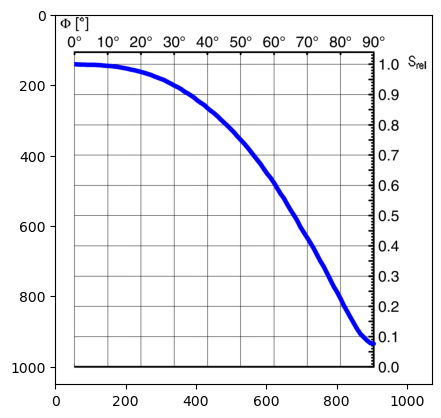

In [4]:
image = cv2.imread("E://Hardware Design/Electronics/PCB/OENN/Modular V2/SFH2704 Directional.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)

In [5]:
# Define the blue color range, we'll look for the exact color #0000FF.
# OpenCV uses BGR format, so the color would be (255, 0, 0).
blue_lower = np.array([255, 0, 0], dtype="uint8")
blue_upper = np.array([255, 0, 0], dtype="uint8")

# Create a mask to only select the blue parts of the image.
color_mask = cv2.inRange(image, blue_lower, blue_upper)

# Detect edges
edges = cv2.Canny(color_mask, 50, 250)

Text(0.5, 1.0, 'Extracted Datapoints (pixels)')

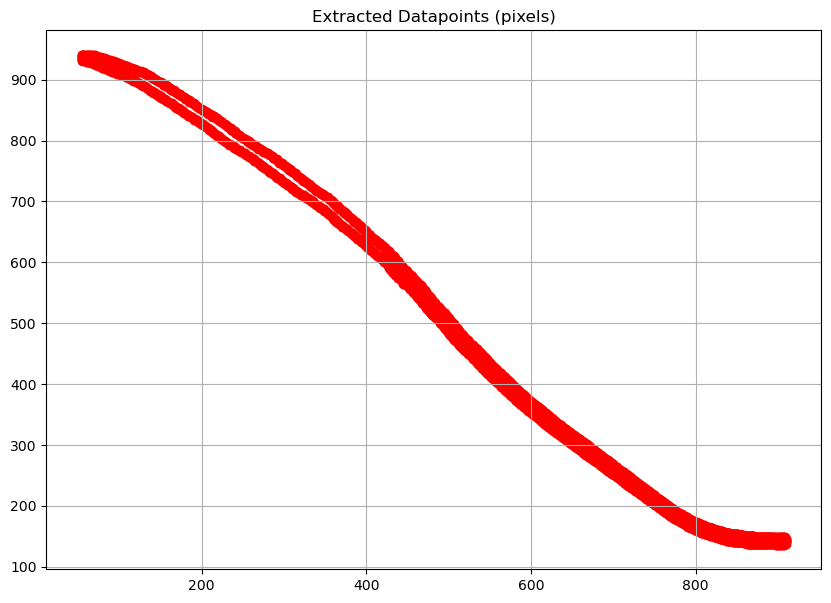

In [11]:
# Extract pixel coordinates
y, x = np.where(edges == 255)
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = np.flip(y[sorted_indices])

plt.figure(figsize=(10, 7))
plt.grid(True)
plt.scatter(x_sorted, y_sorted, color='red')
plt.title('Extracted Datapoints (pixels)')

In [14]:
# Convert pixel coordinates to data values using provided reference points
ref_pixel_x1, ref_pixel_y1 = x_sorted[0], y_sorted[0]
ref_pixel_x2, ref_pixel_y2 = x_sorted[-1], y_sorted[-1]
ref_data_x1, ref_data_y1 = 0, 1
ref_data_x2, ref_data_y2 = 90, 0.08

# Scaling the data based on the selected data points
x_scale_factor = (ref_data_x2 - ref_data_x1) / (ref_pixel_x2 - ref_pixel_x1)
y_scale_factor = (ref_data_y2 - ref_data_y1) / (ref_pixel_y2 - ref_pixel_y1)
data_x = ref_data_x1 + (x_sorted - ref_pixel_x1) * x_scale_factor
data_y = ref_data_y1 + (y_sorted - ref_pixel_y1) * y_scale_factor

data_points = list(zip(data_x, data_y))

In [21]:
data_avg_y = []
data_avg_x = []
unique_indices = np.unique(data_x)

for index in unique_indices:
    corresponding_y = [y for x, y in data_points if x == index]
    average_y = sum(corresponding_y) / len(corresponding_y)
    data_avg_x.append(index)
    data_avg_y.append(average_y)
    
data_avg_x = np.array(data_avg_x)
data_avg_y = np.array(data_avg_y)

data_points_avg = list(zip(data_avg_x, data_avg_y))

Text(0.5, 1.0, 'Extracted Datapoints (scaled)')

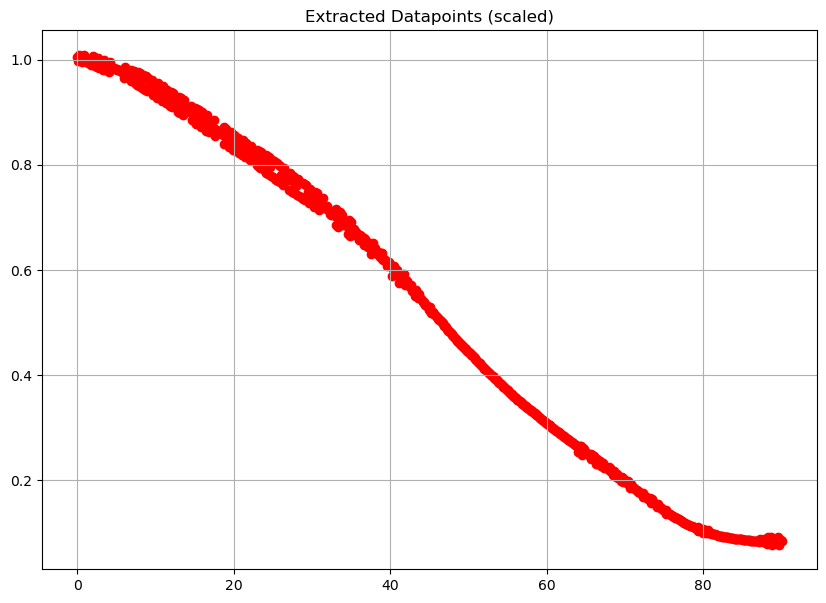

In [20]:
plt.figure(figsize=(10, 7))
plt.grid(True)
plt.scatter(data_avg_x, data_avg_y, color='red')
plt.title('Extracted Datapoints (scaled)')

In [47]:
# Extending the data-points
mirrored_data_points = [(x_val, y_val) for x_val, y_val in data_points_avg]
mirrored_data_points.reverse()
mirrored_data_points = [(-x_val, y_val) for x_val, y_val in mirrored_data_points]

extended_data_points = data_points_avg + mirrored_data_points

Text(0.5, 1.0, 'Extended Datapoints (scaled)')

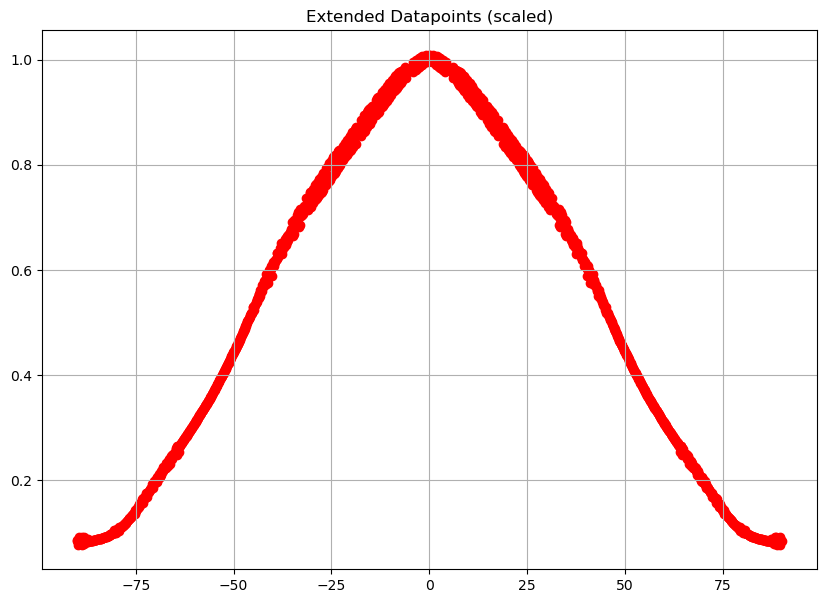

In [48]:
# Plot the data points
plt.figure(figsize=(10, 7))
x_values = [point[0] for point in extended_data_points]
y_values = [point[1] for point in extended_data_points]
plt.scatter(x_values, y_values, color='red')
plt.grid(True)
plt.title('Extended Datapoints (scaled)')

In [75]:
# Fitting a polynomila to the calculated data points
angles = np.array([point[0] for point in extended_data_points])
relative_sensitivity = np.array([point[1] for point in extended_data_points])
relative_sensitivity = relative_sensitivity/np.max(relative_sensitivity)

# Sorting the arrays
sorted_indices = np.argsort(angles)
angles = angles[sorted_indices]
relative_sensitivity = relative_sensitivity[sorted_indices]

# Fitting the data to a polynomial
degree = 7
relative_sensitivity_fit = np.polynomial.Polynomial.fit(angles, relative_sensitivity, degree)


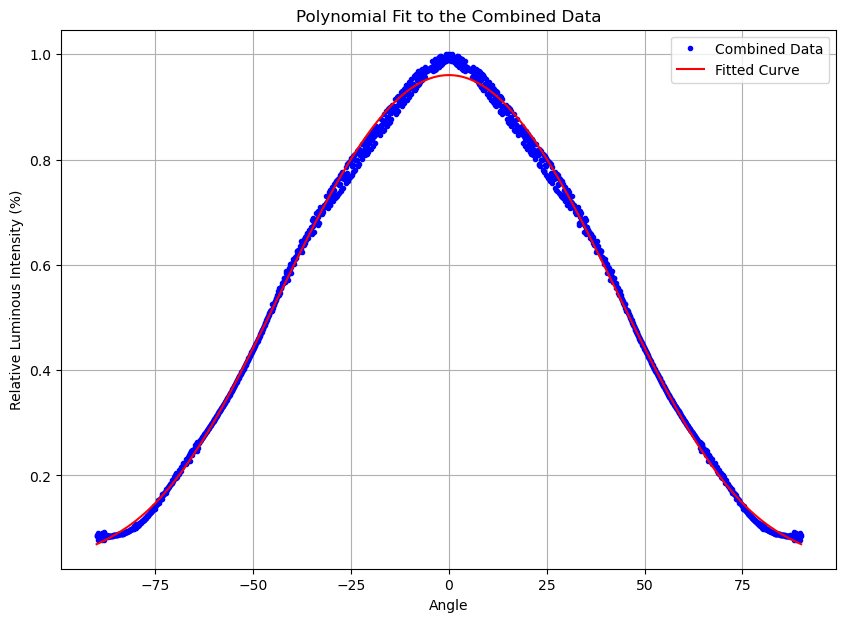

In [76]:
# Plotting the fitted polynomial
plt.figure(figsize=(10, 7))
plt.plot(angles, relative_sensitivity, '.', label="Combined Data", color='blue')
plt.plot(angles, relative_sensitivity_fit(np.array(angles)), '-', label="Fitted Curve", color='red')
plt.title("Polynomial Fit to the Combined Data")
plt.xlabel("Angle")
plt.ylabel("Relative Luminous Intensity (%)")
plt.legend()
plt.grid(True)
plt.show()

Text(0, 0.5, 'Relative Luminous Intensity (%)')

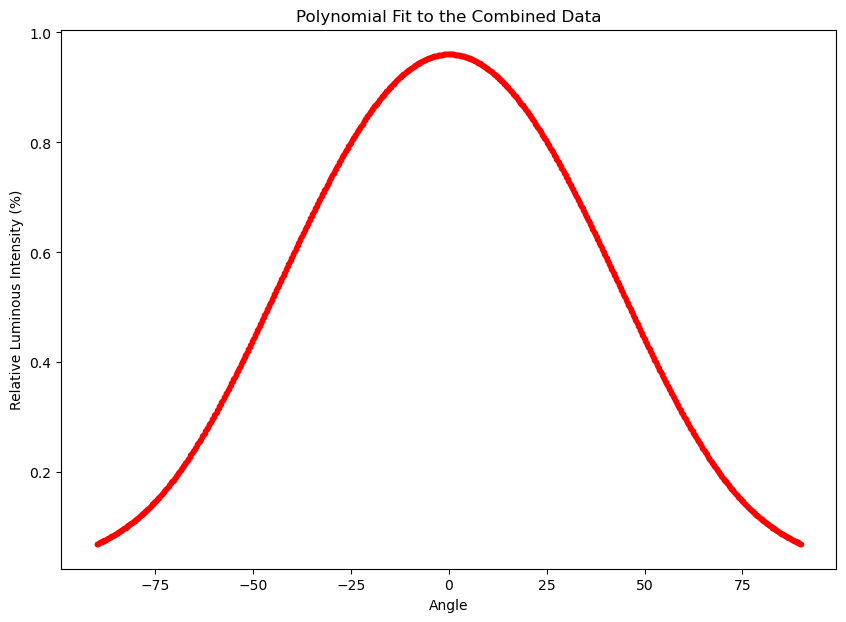

In [79]:
# Generate a new array of values based on the fitted polynomial
angles_fine = np.linspace(min(angles), max(angles), 1000)
relative_sensitivity_fine = relative_sensitivity_fit(angles_fine)

# Plotting the fitted polynomial
plt.figure(figsize=(10, 7))
plt.plot(angles_fine, relative_sensitivity_fine, '.', label="Fitted Curve", color='red')
plt.title("Polynomial Fit to the Combined Data")
plt.xlabel("Angle")
plt.ylabel("Relative Luminous Intensity (%)")

In [81]:
# Saving the fitted data to a CSV file
with open("out/Power/SFH2704 Directional Fit.csv", 'w') as f:
    f.write("Angle,Relative Luminous Intensity\n")
    for point in zip(angles_fine, relative_sensitivity_fine):
        f.write(f"{point[0]},{point[1]}\n")

## Dark Current

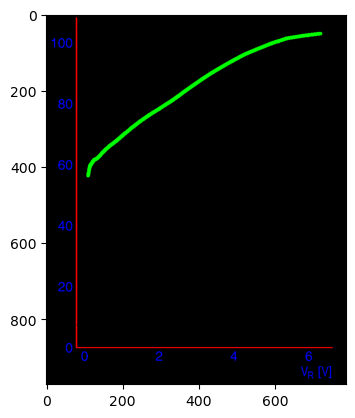

In [46]:
file_loc_sfh_dc = 'E:\Hardware Design\Electronics\PCB\OENN\Modular V2\SFH2704 Dark Current (Edit).png'

sfh_dc = cv2.imread(file_loc_sfh_dc)
sfh_dc_rgb = cv2.cvtColor(sfh_dc, cv2.COLOR_BGR2RGB)

# Binarize each individual channel
_, sfh_dc_r = cv2.threshold(sfh_dc_rgb[:, :, 0], 200, 255, cv2.THRESH_BINARY)
_, sfh_dc_g = cv2.threshold(sfh_dc_rgb[:, :, 1], 200, 255, cv2.THRESH_BINARY)
_, sfh_dc_b = cv2.threshold(sfh_dc_rgb[:, :, 2], 200, 255, cv2.THRESH_BINARY)

# Merge the three channels into a single 3D array
sfh_dc_rgb = np.dstack((sfh_dc_r, sfh_dc_g, sfh_dc_b))

plt.imshow(sfh_dc_rgb)

# Splitting into channels
sfh_dc_channels = cv2.split(sfh_dc_rgb)

In [66]:
# plt.imshow(sfh_dc_channels[1], cmap='gray')

# Extract the pixel positions of points in sfh_dc_channels[1] 
sfh_dc_positions = np.where(sfh_dc_channels[1] != 0)

# First and last points in the plot for converting to real coordinates
first_point = [0.1, 56]
last_point = [6.7, 103]

# Calculate the scale factor
scale_factor_x = (last_point[0] - first_point[0]) / (sfh_dc_positions[0][-1] - sfh_dc_positions[0][0])
scale_factor_y = (last_point[1] - first_point[1]) / (sfh_dc_positions[1][-1] - sfh_dc_positions[1][0])

# Calculate the actual positions
sfh_dc_positions_x = first_point[0] + (sfh_dc_positions[0] - sfh_dc_positions[0][0]) * scale_factor_x
sfh_dc_positions_y = first_point[1] + (sfh_dc_positions[1] - sfh_dc_positions[1][0]) * scale_factor_y

# Combine the positions into a single array
sfh_dc_positions = np.array([sfh_dc_positions_x, sfh_dc_positions_y])

In [84]:
def sfh_dc_fit_func(x, a, c):
    return a * np.sqrt(x) + c 

# Fit the data to the function
popt, pcov = curve_fit(sfh_dc_fit_func, sfh_dc_positions[0], sfh_dc_positions[1])

# Generate a new array of values based on the fitted polynomial
sfh_dc_positions_fine = np.linspace(min(sfh_dc_positions[0]), max(sfh_dc_positions[0]), 1000)
sfh_dc_fit_fine = sfh_dc_fit_func(sfh_dc_positions_fine, *popt)


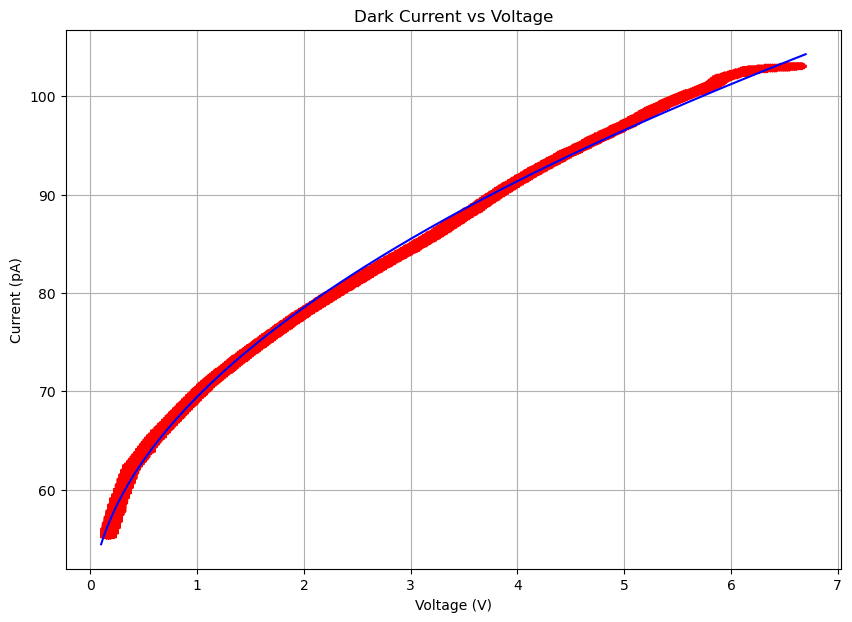

In [89]:
# Plot the curve of sfh_dc_positions
plt.figure(figsize=(10, 7))
plt.plot(sfh_dc_positions[0], sfh_dc_positions[1], color='red')
plt.plot(sfh_dc_positions_fine, sfh_dc_fit_fine, color='blue')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (pA)')
plt.title('Dark Current vs Voltage')
plt.grid(True)
plt.show()

In [86]:
# Save the data to a CSV file
with open("out/Power/SFH2704 Dark Current.csv", 'w') as f:
    f.write("Voltage,Current\n")
    for point in zip(sfh_dc_positions_fine, sfh_dc_fit_fine):
        f.write(f"{point[0]},{point[1]}\n")

In [88]:
sfh_dc_fit_func(4, *popt)

91.37995884647177